In [1]:
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.analysis import *
from kpnet.patterns import *

from wavelets import *

In [11]:
neurons = 64
time_interval = 200000

In [12]:
np.random.seed(0)
neuron = 5
net = KPNetworkTanhDelayed(neurons, 3, alpha=0.06, beta=0.2, gamma=3.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

#for i in range(2, 5):
#    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 189, i)

for i in range(neurons):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, i, neuron)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)

CPU times: user 43.4 s, sys: 57.4 ms, total: 43.4 s
Wall time: 43.4 s


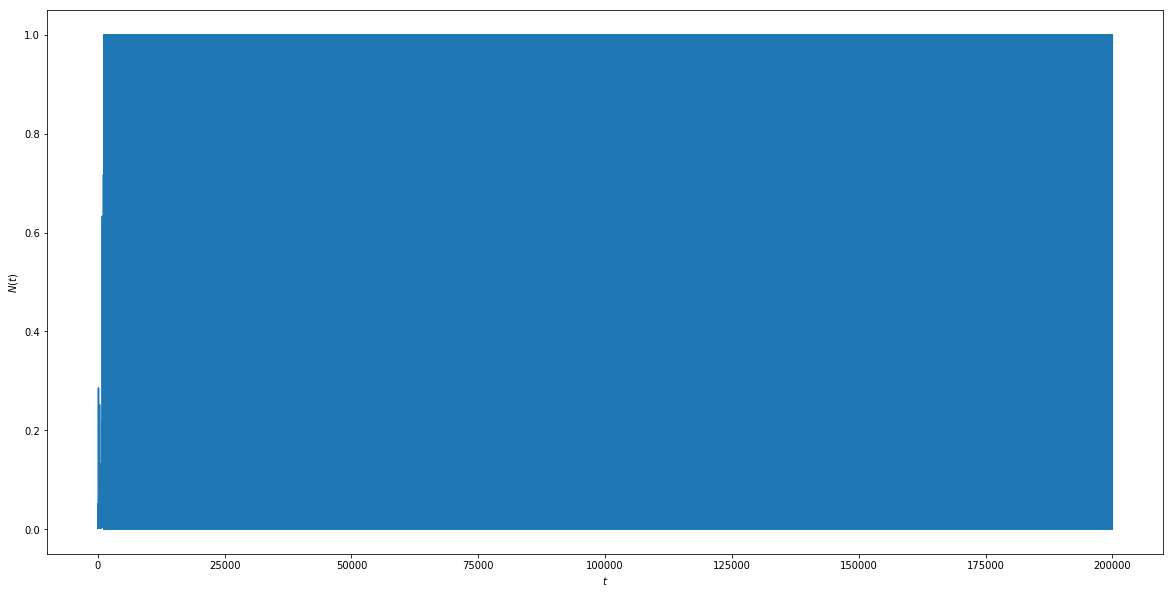

In [13]:
plt.figure(figsize=(20, 10))
plt.plot(results['N_5'])
plt.ylabel(r'$N(t)$')
plt.xlabel(r'$t$')
plt.show()

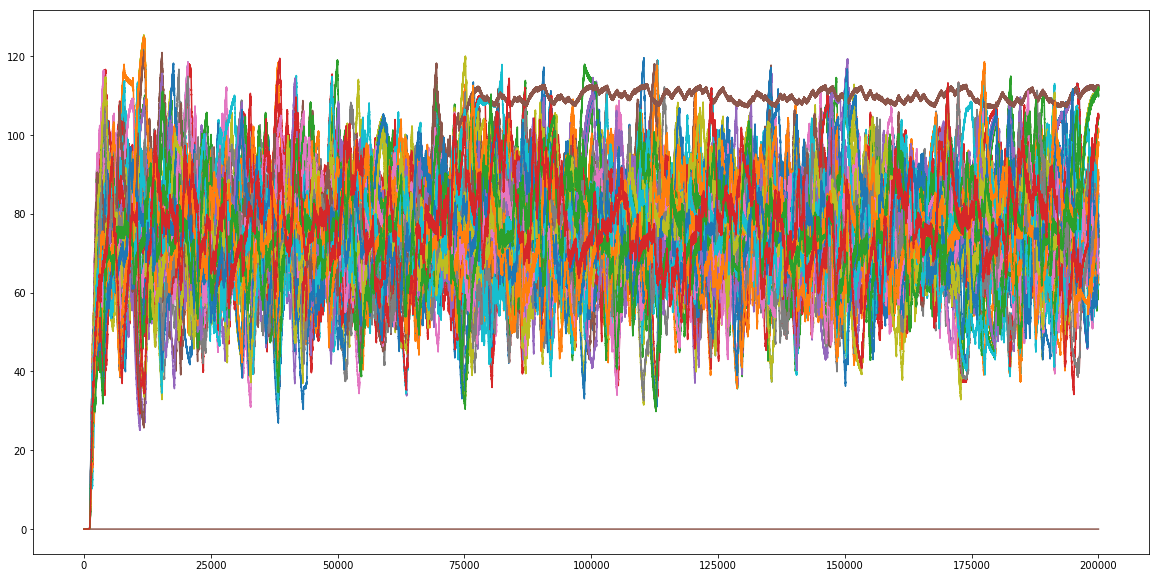

In [14]:
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(neurons):
    plt.plot(results['W_' + str(i)])
plt.show()

# Интересно!!!!!!!!!!!!!!!!!!